In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="6"

Wed Jan 24 19:42:33 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   33C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.9999

hp.M = hp.n_prior_embeddings

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_uniform_notconst_1e-5/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 440475, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

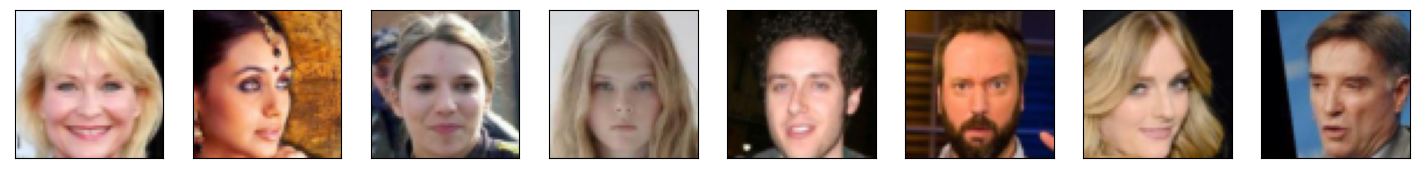

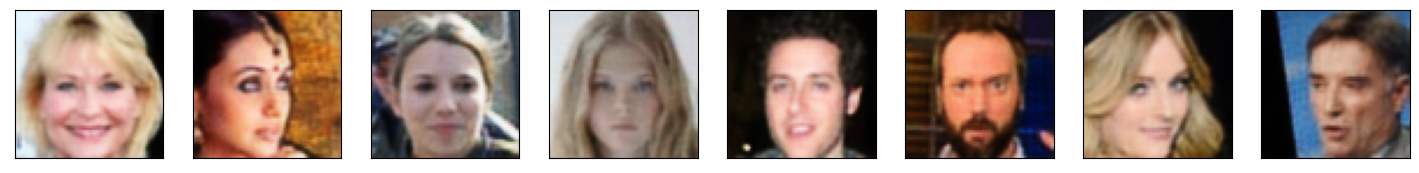

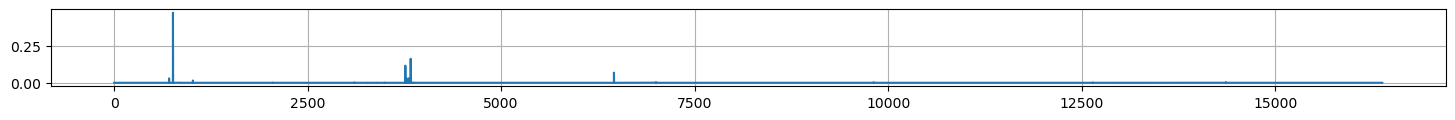

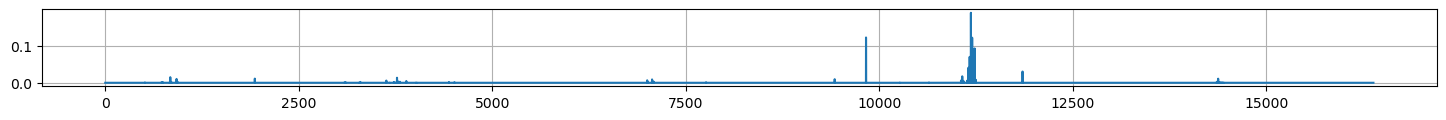

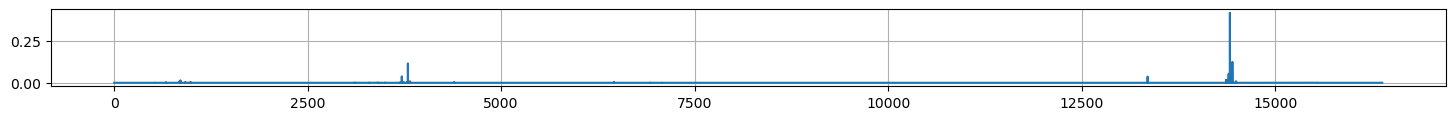

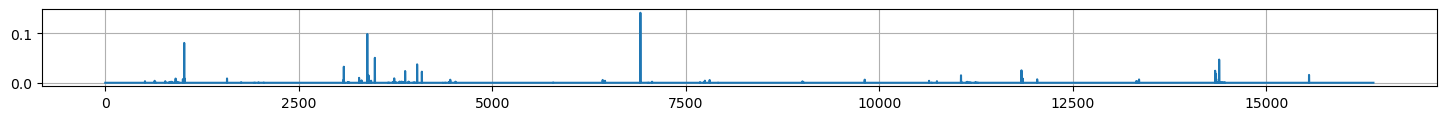

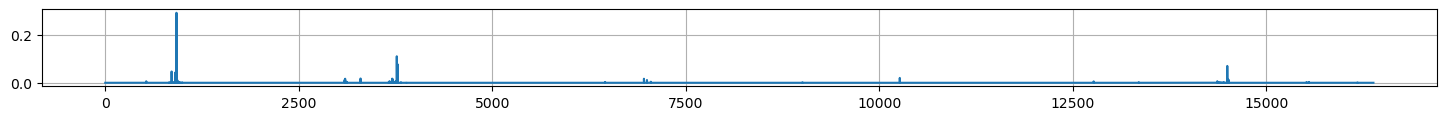

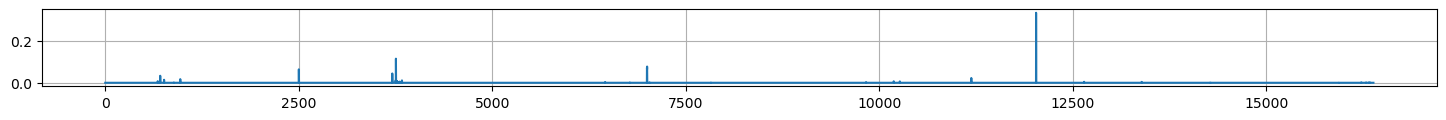

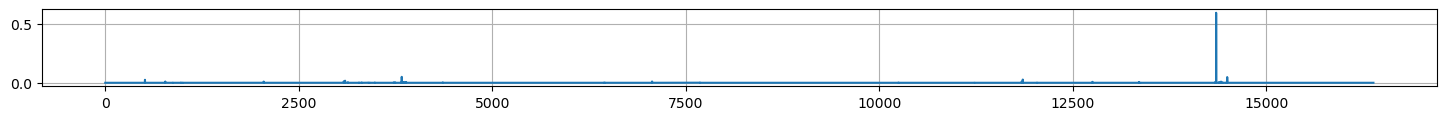

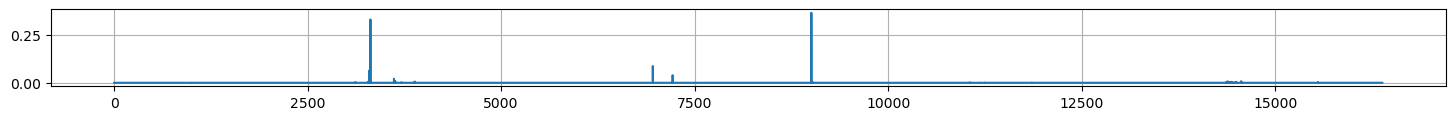

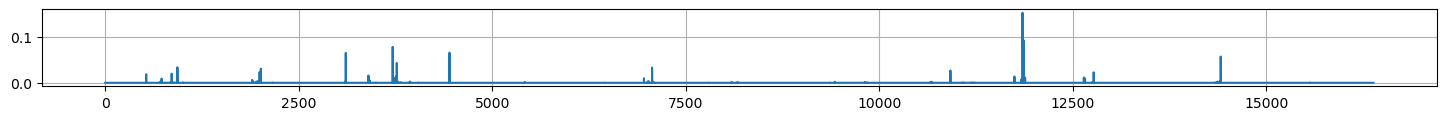

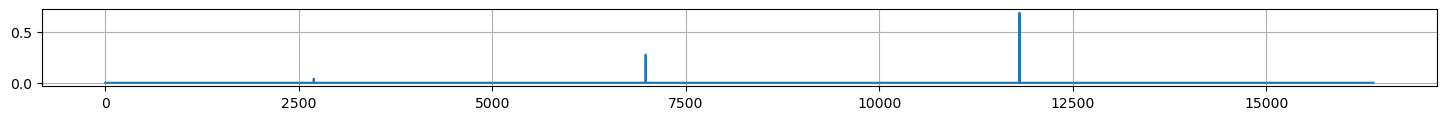

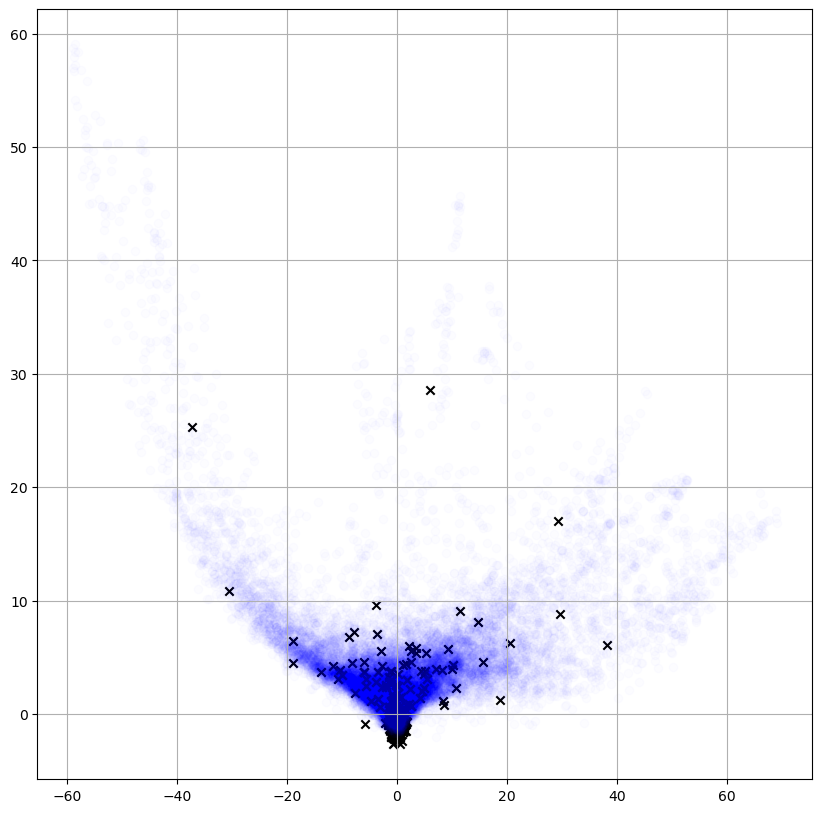

13001
lse_loss -33.663455963134766
commit_loss 0.8240073323249817
recon_loss 0.0005786683177575469
13002
lse_loss -34.08570098876953
commit_loss 0.9310488700866699
recon_loss 0.0005659565795212984
13003
lse_loss -33.684635162353516
commit_loss 0.8787496089935303
recon_loss 0.0005890228203497827
13004
lse_loss -33.43825912475586
commit_loss 0.983934760093689
recon_loss 0.00057679892051965
13005
lse_loss -33.890357971191406
commit_loss 0.9170137643814087
recon_loss 0.0005704656941816211
13006
lse_loss -33.89057159423828
commit_loss 0.8278969526290894
recon_loss 0.0007458882173523307
13007
lse_loss -33.76570510864258
commit_loss 0.8192824125289917
recon_loss 0.0005930936895310879
13008
lse_loss -33.67097091674805
commit_loss 0.8292922973632812
recon_loss 0.0005684261559508741
13009
lse_loss -33.70390701293945
commit_loss 0.8338919878005981
recon_loss 0.0006080036982893944
13010
lse_loss -33.65413284301758
commit_loss 0.832463264465332
recon_loss 0.0005863381084054708
13011
lse_loss -33.72

13086
lse_loss -33.746585845947266
commit_loss 1.0003507137298584
recon_loss 0.0006072677206248045
13087
lse_loss -33.728153228759766
commit_loss 0.8155187368392944
recon_loss 0.0007007452077232301
13088
lse_loss -32.99876022338867
commit_loss 0.877313494682312
recon_loss 0.000568675750400871
13089
lse_loss -33.835975646972656
commit_loss 0.9138510823249817
recon_loss 0.0005819108919240534
13090
lse_loss -34.09092330932617
commit_loss 0.8330062031745911
recon_loss 0.0006631747237406671
13091
lse_loss -33.840938568115234
commit_loss 0.8680753111839294
recon_loss 0.0006288124714046717
13092
lse_loss -33.748260498046875
commit_loss 0.8434606194496155
recon_loss 0.0005948536563664675
13093
lse_loss -33.5596923828125
commit_loss 1.0469825267791748
recon_loss 0.0006171534769237041
13094
lse_loss -33.384849548339844
commit_loss 0.9242770075798035
recon_loss 0.0006351674674078822
13095
lse_loss -33.68569564819336
commit_loss 0.9741412401199341
recon_loss 0.0006472058012150228
13096
lse_loss -3

13171
lse_loss -34.116519927978516
commit_loss 0.8688417077064514
recon_loss 0.0008657490834593773
13172
lse_loss -34.174400329589844
commit_loss 0.8626512289047241
recon_loss 0.0005461705150082707
13173
lse_loss -33.65285873413086
commit_loss 0.9035516977310181
recon_loss 0.0006109978421591222
13174
lse_loss -33.53628921508789
commit_loss 0.8765608072280884
recon_loss 0.0007046912796795368
13175
lse_loss -32.81315231323242
commit_loss 1.0255948305130005
recon_loss 0.0009455927647650242
13176
lse_loss -33.479949951171875
commit_loss 0.8080816268920898
recon_loss 0.0005914036300964653
13177
lse_loss -33.80664825439453
commit_loss 0.9762325286865234
recon_loss 0.0007232384523376822
13178
lse_loss -33.58855056762695
commit_loss 0.8275011777877808
recon_loss 0.0006407425389625132
13179
lse_loss -33.67587661743164
commit_loss 0.8733339309692383
recon_loss 0.0007523493841290474
13180
lse_loss -33.69918441772461
commit_loss 0.887681782245636
recon_loss 0.0010999710066244006
13181
lse_loss -33

lse_loss -33.855037689208984
commit_loss 0.9243670701980591
recon_loss 0.0009020682191476226
13256
lse_loss -33.69471740722656
commit_loss 0.8770904541015625
recon_loss 0.0005445803981274366
13257
lse_loss -33.867435455322266
commit_loss 0.8004152774810791
recon_loss 0.0005844664410687983
13258
lse_loss -33.74722671508789
commit_loss 1.1075084209442139
recon_loss 0.0006512549589388072
13259
lse_loss -33.52315139770508
commit_loss 1.1260321140289307
recon_loss 0.0007394477725028992
13260
lse_loss -33.125125885009766
commit_loss 0.8961407542228699
recon_loss 0.0009397060493938625
13261
lse_loss -33.884864807128906
commit_loss 1.0633900165557861
recon_loss 0.0006577024469152093
13262
lse_loss -34.08332061767578
commit_loss 0.9404023885726929
recon_loss 0.0006826122989878058
13263
lse_loss -32.777587890625
commit_loss 0.9432669878005981
recon_loss 0.0005549954948946834
13264
lse_loss -34.1154899597168
commit_loss 0.8681545853614807
recon_loss 0.0007669780752621591
13265
lse_loss -33.443824

13341
lse_loss -33.48963165283203
commit_loss 0.8487509489059448
recon_loss 0.0006052746903151274
13342
lse_loss -33.83755111694336
commit_loss 0.8663742542266846
recon_loss 0.0005872243782505393
13343
lse_loss -33.6076545715332
commit_loss 0.8868789672851562
recon_loss 0.0006837117834948003
13344
lse_loss -33.80881118774414
commit_loss 0.903762936592102
recon_loss 0.0006521313334815204
13345
lse_loss -33.93881607055664
commit_loss 0.8836553692817688
recon_loss 0.0005477163940668106
13346
lse_loss -34.050601959228516
commit_loss 0.9521700739860535
recon_loss 0.0005327666294761002
13347
lse_loss -33.94578170776367
commit_loss 0.8683034181594849
recon_loss 0.0005672675324603915
13348
lse_loss -33.620140075683594
commit_loss 0.845991313457489
recon_loss 0.0006379552069120109
13349
lse_loss -33.80767059326172
commit_loss 0.8645787239074707
recon_loss 0.0005643870099447668
13350
lse_loss -34.104835510253906
commit_loss 0.9827515482902527
recon_loss 0.0006770309992134571
13351
lse_loss -33.8

lse_loss -34.10198211669922
commit_loss 0.7930489778518677
recon_loss 0.0005904840072616935
13427
lse_loss -34.041534423828125
commit_loss 0.7339441776275635
recon_loss 0.0006251569138839841
13428
lse_loss -32.906314849853516
commit_loss 0.8446488976478577
recon_loss 0.0006215869216248393


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-5
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [25]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


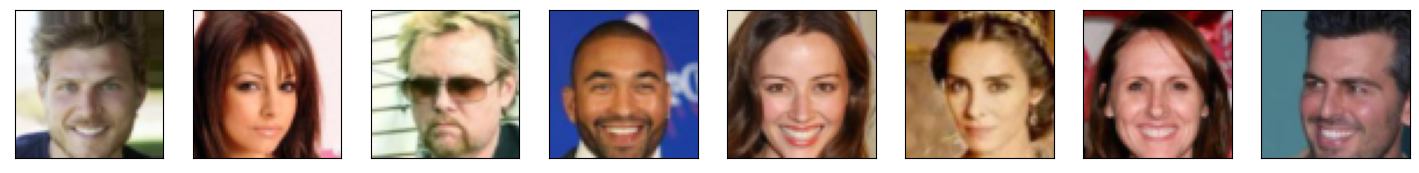

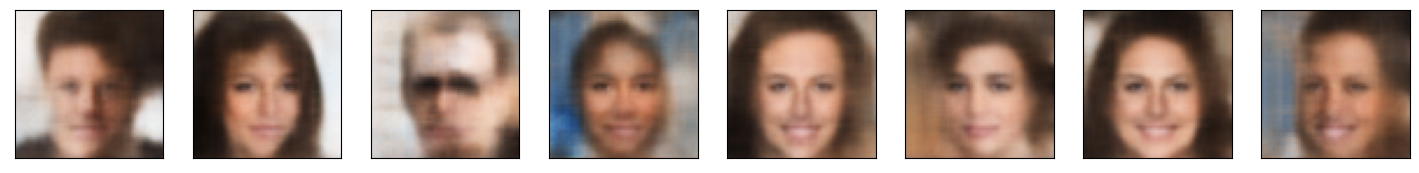

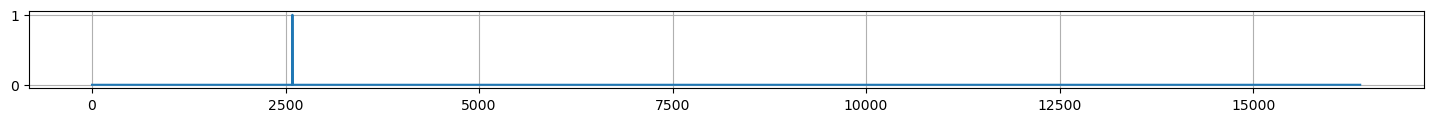

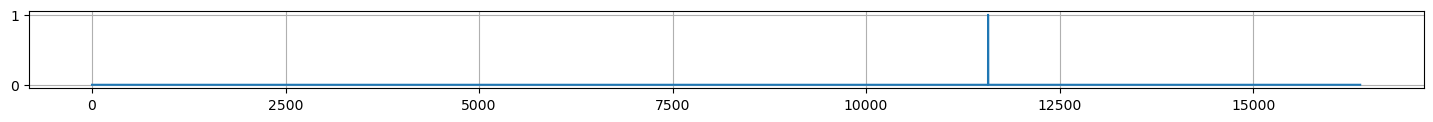

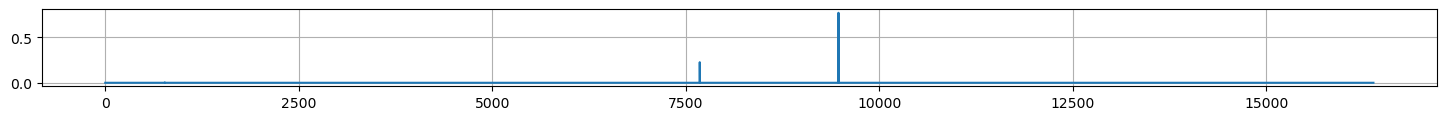

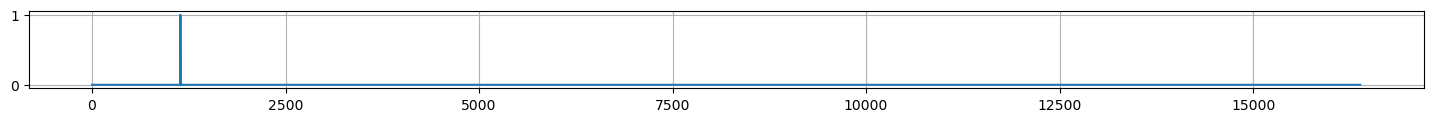

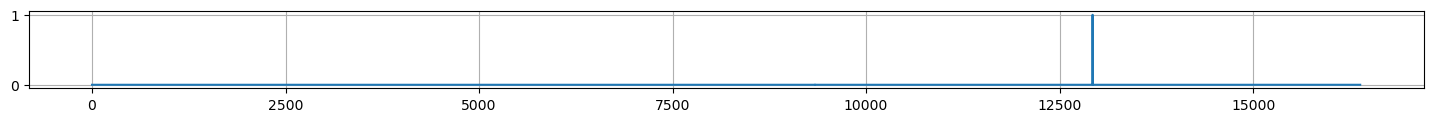

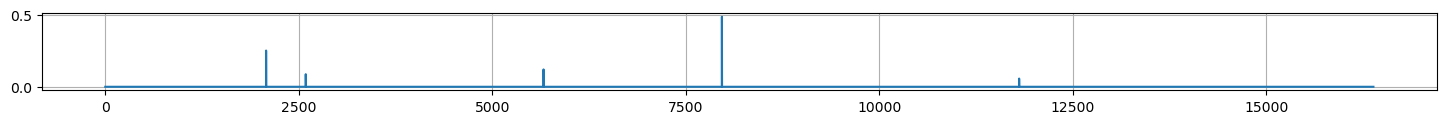

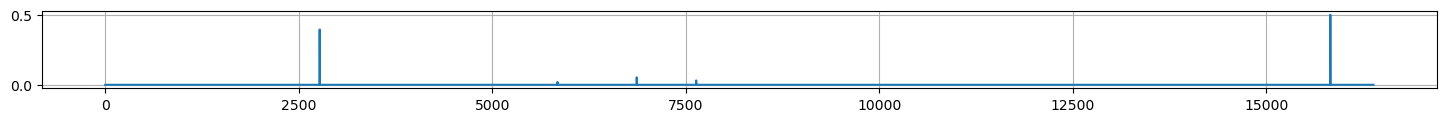

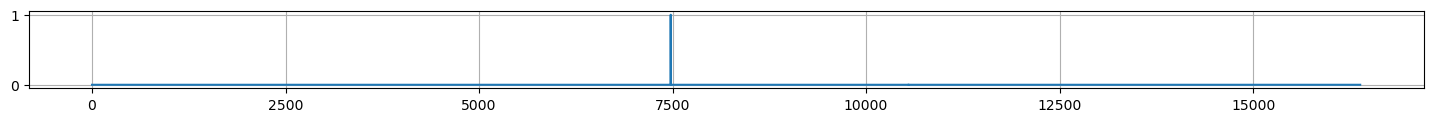

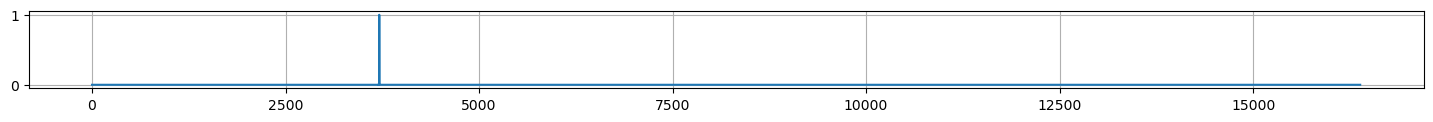

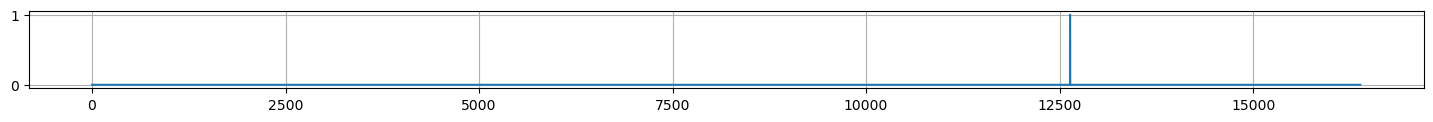

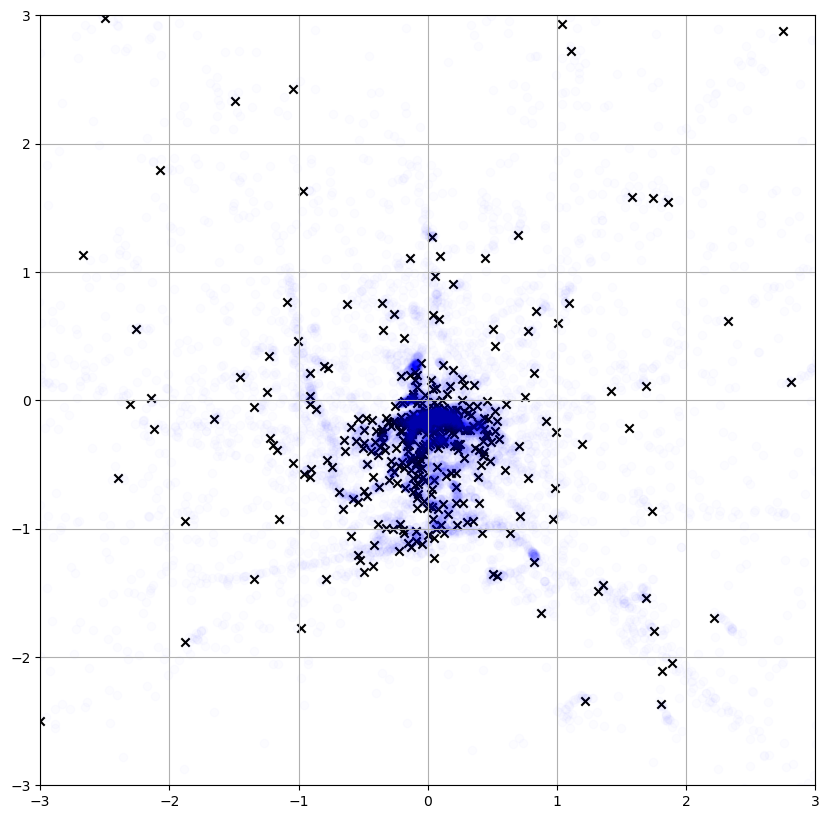

In [23]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.grid()
plt.show() 

In [32]:
from tqdm import tqdm

belongs = []
for i, batch in tqdm(enumerate(train_loader)):
    data = preprocess(batch)

    # Forward
    model.eval()
    data = model(data, latent_temp=1)
    belongs.append(data['belong'])

    if i > 2:
        break

3it [00:00, 10.83it/s]


In [33]:
belongs = torch.stack(belongs, dim=0)
print(belongs.shape)

torch.Size([4, 16384, 512])


In [34]:
(belongs.sum(dim=[0, 1]) > 0).sum()

tensor(512, device='cuda:0')